<a href="https://colab.research.google.com/github/Arjun2099/Scaling-Neuron-Models-with-GPU/blob/AdEx-Model-tests/AdEx_Model_test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Function to stimulate multiple number of neurons

In [1]:
import math
import matplotlib.pyplot as plt

In [32]:
class AdExCell:
    def __init__(self):
        self.Cm = 200
        self.Gl = 10
        self.El = -70
        self.delta = 2
        self.Vt = -50
        self.a = 2
        self.Tw = 30
        self.b = 0
        self.Vr = -58
        self.Vm = -70
        self.w = 0
        self.Iin = 500
        self.ISynArray = []

class Experiment:
    def __init__(self, start, end, dt, inI):
        self.StartTime = start
        self.EndTime = end
        self.dt = dt
        self.InI = inI

class AdExModel(AdExCell):
    def __init__(self, ex, ID):
        super().__init__()
        self.E = ex
        self.id = ID
        self.size = int((self.E.EndTime - self.E.StartTime) / self.E.dt)
        self.VmArray = [0.0] * (self.size + 2)
        self.IStimArray = [0.0] * (self.size + 2)
        self.IsRoot = True
        self.Iin = ex.InI
        self.TimeArray = []
        self.wArray = []
        self.Vm = self.Vr  # Initialize Vm
        self.ISynArray = [0.0] * (self.size + 2)  # Initialize ISynArray

    def stimulate(self, paramTuple):
        Cm, Gl, El, Vt, delta, a, Tw, b, Vr, Iin = paramTuple
        if Cm is not None:
            self.Cm = Cm
        if Gl is not None:
            self.Gl = Gl
        if El is not None:
            self.El = El
        if delta is not None:
            self.delta = delta
        if Vt is not None:
            self.Vt = Vt
        if a is not None:
            self.a = a
        if Tw is not None:
            self.Tw = Tw
        if b is not None:
            self.b = b
        if Vr is not None:
            self.Vr = Vr
        if Iin is not None:
            self.Iin = Iin

        print("Inside AdEx firing...")
        elapsed = self.E.StartTime
        i = 0
        self.TimeArray.append(elapsed)
        self.VmArray[i] = self.Vm
        self.wArray.append(self.w)
        while elapsed <= self.E.EndTime:
            if not self.IsRoot:
                self.Iin = self.ISynArray[i]
            i += 1
            self.RungekuttaSolver_AdExLif(elapsed, self.Vm, self.w, self.Iin)
            if self.Vm > -32:
                self.VmArray[i] = 30
                self.Vm = self.Vr
                self.w += self.b
            else:
                self.VmArray[i] = self.Vm
            self.TimeArray.append(elapsed)
            self.wArray.append(self.w)
            elapsed += self.E.dt
        self.StoreData(self.VmArray, self.TimeArray, self.wArray, self.size)
        return self.VmArray

    # Custom exponential function so that math range error is not occured
    def custom_exp(self, x):
        if x > 100:
            return float('inf')
        elif x < -100:
            return 0.0
        else:
            return math.exp(x)

    def getAdaptation(self):
        return self.wArray

    def RungekuttaSolver_AdExLif(self, t, Vm, w, input):
        k1_v, k2_v, k3_v, k4_v, KV = 0, 0, 0, 0, 0
        k1_w, k2_w, k3_w, k4_w, KW = 0, 0, 0, 0, 0

        k1_v = self.DeltaV(t, Vm, w, input)
        k1_w = self.DeltaW(t, Vm, w)

        k2_v = self.DeltaV(t + self.E.dt / 2, Vm + (self.E.dt / 2) * k1_v, w + (self.E.dt / 2) * k1_v, input)
        k2_w = self.DeltaW(t + self.E.dt / 2, Vm + (self.E.dt / 2) * k1_w, w + (self.E.dt / 2) * k1_w)

        k3_v = self.DeltaV(t + self.E.dt / 2, Vm + (self.E.dt / 2) * k2_v, w + (self.E.dt / 2) * k2_v, input)
        k3_w = self.DeltaW(t + self.E.dt / 2, Vm + (self.E.dt / 2) * k2_w, w + (self.E.dt / 2) * k2_w)

        k4_v = self.DeltaV(t + self.E.dt, Vm + self.E.dt * k3_v, w + self.E.dt * k3_v, input)
        k4_w = self.DeltaW(t + self.E.dt, Vm + self.E.dt * k3_w, w + self.E.dt * k3_w)

        KV = self.E.dt * ((k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6)
        self.Vm += KV
        KW = self.E.dt * ((k1_w + 2 * k2_w + 2 * k3_w + k4_w) / 6)
        self.w += KW

    def DeltaV(self, t, v, w, input):
        if self.IsRoot:
            return ((-self.Gl * (v - self.El) + self.Gl * self.delta * (self.custom_exp((v - self.Vt) / self.delta)) - w + input) / self.Cm)
        elif not self.IsRoot:
            return ((-self.Gl * (v - self.El) + self.Gl * self.delta * (self.custom_exp((v - self.Vt) / self.delta)) - w - input) / self.Cm)
        else:
            return 0

    def plot_results(self):
        plt.figure(figsize=(10, 9))
        plt.subplot(3, 1, 1)
        plt.plot(self.TimeArray, self.VmArray, label='Vm')
        plt.xlabel('Time')
        plt.ylabel('Membrane Potential (Vm)')
        plt.legend()
        plt.xlim(0, 200)

        plt.subplot(3, 1, 2)
        plt.plot(self.TimeArray, self.wArray, label='w', color='orange')
        plt.xlabel('Time')
        plt.ylabel('Adaptation Current (w)')
        plt.legend()
        plt.xlim(0, 200)

        plt.subplot(3, 1, 3)
        plt.plot(self.VmArray, self.wArray, label='w vs V', color='green')
        plt.xlabel('Membrane Potential (Vm)')
        plt.ylabel('Adaptation Current (w)')
        plt.legend()

        plt.tight_layout()
        plt.show()


    def DeltaW(self, t, v, w):
        return ((self.a * (v - self.El) - w) / self.Tw)

    def StoreData(self, v, t, w, size):
        print("Inside AdEx store data...")
        filename = "AdExResult" + str(self.id) + ".csv"
        with open(filename, "w") as f:
            f.write("Time,Voltage,w\n")
            for i in range(size):
                f.write(f"{t[i]},{v[i]},{w[i]}\n")

class NeuronSimulator:
    def __init__(self, InI, startTime, endTime, dt, neuronNo, neuron_type):
        self.ex = Experiment(startTime, endTime, dt, InI)
        self.neurons = []
        self.neuron_type = neuron_type
        self.neuron_params = {
            "tonic": (200, 10, -70, -50, 2, 2, 30, 0, -58, InI),
            "adaptation": (200, 12, -70, -50, 2, 2, 300, 60, -58, InI),
            "initialBurst": (130, 18, -58, -50, 2, 4, 150, 120, -50, InI),
            "regularBursting": (200, 10, -58, -50, 2, 2, 120, 100, -46, InI),
            "delayedAccelerating": (200, 12, -70, -50, 2, -10, 300, 0, -58, InI),
            "delayedRegularBursting": (200, 10, -70, -40, 2, 2, 100, 100, -58, InI),
            "transientSpiking": (100, 10, -65, -50, 2, -10, 90, 30, -47, InI),
            "irregularSpiking": (100, 12, -60, -50, 2, -11, 130, 30, -48, InI),
        }

        for i in range(neuronNo):
            neuron_id = f"{neuron_type}_{i+1}"
            neuron = AdExModel(self.ex, neuron_id)
            self.neurons.append(neuron)

    def run_simulation(self):
        params = self.neuron_params.get(self.neuron_type)
        if params is None:
            print("Invalid neuron type.")
            return

        for neuron in self.neurons:
            neuron.stimulate(params)  # Pass the parameter tuple

    def plot_results(self):
        for neuron in self.neurons:
            print(f"Plotting results for neuron {neuron.id}")
            neuron.plot_results()

    def print_results(self):
        for neuron in self.neurons:
            print(f"Results for neuron {neuron.id}")
            print(f"Vm: {neuron.VmArray}")
            print(f"w: {neuron.wArray}")
            print(f"Time: {neuron.TimeArray}")

def main():
    num_neurons = int(input("Enter the number of neurons: "))
    InI = float(input("Enter input current for the neurons: "))
    startTime = float(input("Enter start time for the experiment: "))
    endTime = float(input("Enter end time for the experiment: "))
    dt = float(input("Enter time step for the experiment: "))
    neuron_type = input("Enter neuron type: ")

    simulator = NeuronSimulator(InI, startTime, endTime, dt, num_neurons, neuron_type)
    simulator.run_simulation()
    simulator.plot_results()
    simulator.print_results()

Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron tonic_1


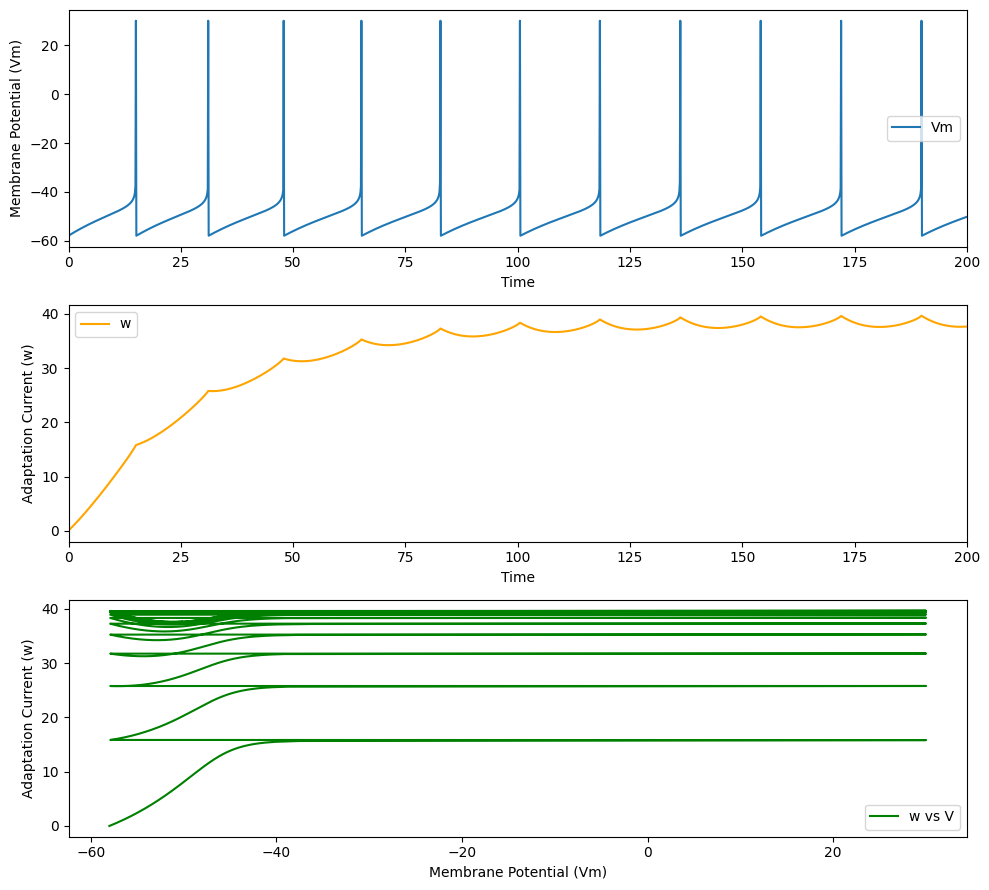

Results for neuron tonic_1
Vm: [-58, -57.88512766021306, -57.7708569778168, -57.657184611598524, -57.54410720639337, -57.431621392055526, -57.31972378239759, -57.20841097409729, -57.097679545570685, -56.98752605581093, -56.8779470431918, -56.76893902423495, -56.66049849233991, -56.55262191647591, -56.445305739834325, -56.3385463784408, -56.232340219725735, -56.126683621052024, -56.02157290819879, -55.9170043737997, -55.81297427573451, -55.70947883547242, -55.60651423636556, -55.5040766218911, -55.40216209384011, -55.30076671045146, -55.19988648448874, -55.099517381258124, -54.99965531656504, -54.900296154607226, -54.80143570580176, -54.703069724543326, -54.60519390689103, -54.50780388818056, -54.410895240558595, -54.31446347043601, -54.21850401585612, -54.123012243774085, -54.02798344724321, -53.93341284250364, -53.83929556596863, -53.74562667110303, -53.65240112518871, -53.55961380597057, -53.46725949817702, -53.375332889907845, -53.28382856888205, -53.192741018537816, -53.10206461397

In [45]:
simulator = NeuronSimulator(350, 0, 200, 0.1, 1, "tonic")
simulator.run_simulation()
simulator.plot_results()
simulator.print_results()

Enter the number of neurons: 1
Enter input current for the neurons: 500
Enter start time for the experiment: 0
Enter end time for the experiment: 200
Enter time step for the experiment: 0.1
Enter neuron type: adaptation
Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron adaptation_1


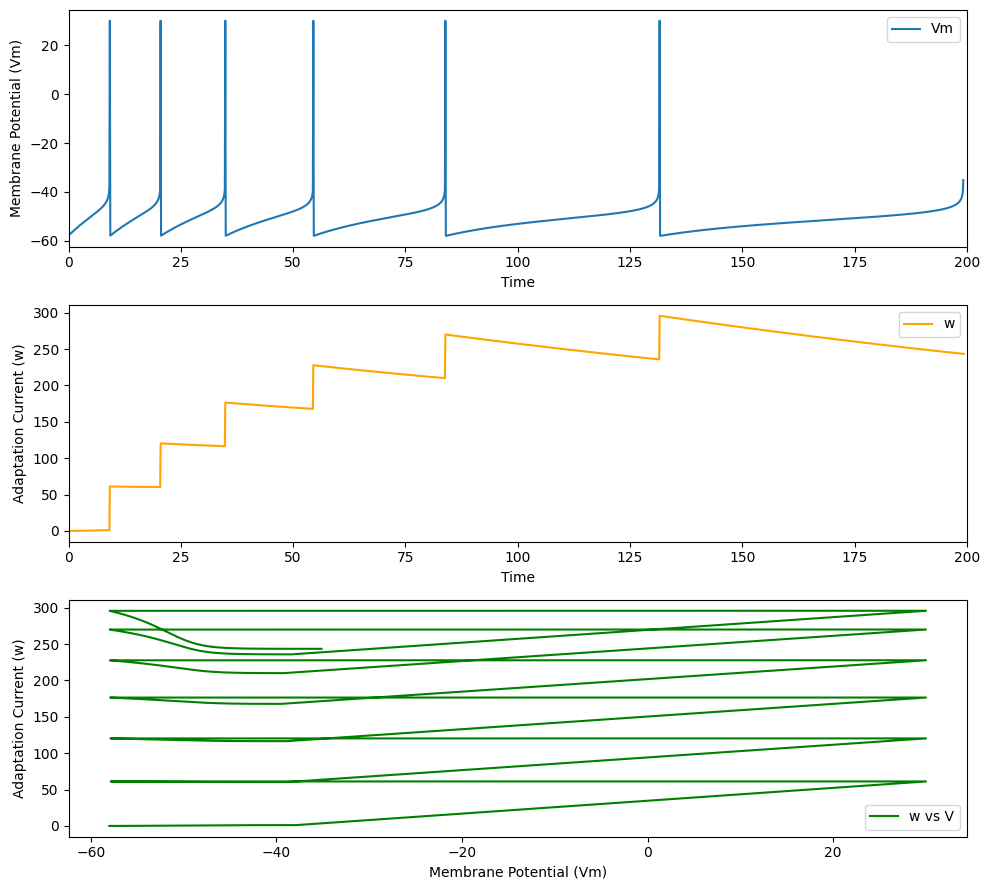

In [ ]:
main()

Enter the number of neurons: 1
Enter input current for the neurons: 400
Enter start time for the experiment: 0
Enter end time for the experiment: 200
Enter time step for the experiment: 0.1
Enter neuron type: initialBurst
Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron initialBurst_1


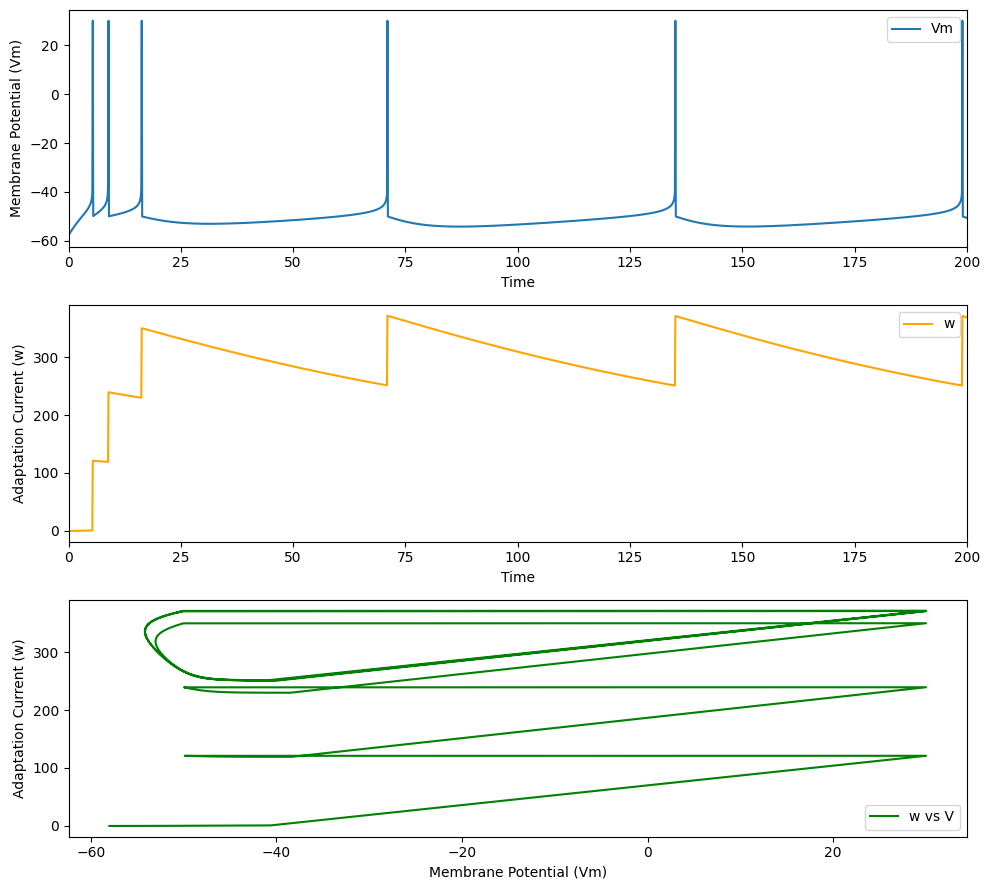

In [ ]:
main()

Enter the number of neurons: 1
Enter input current for the neurons: 210
Enter start time for the experiment: 0
Enter end time for the experiment: 200
Enter time step for the experiment: 0.1
Enter neuron type: regularBursting
Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron regularBursting_1


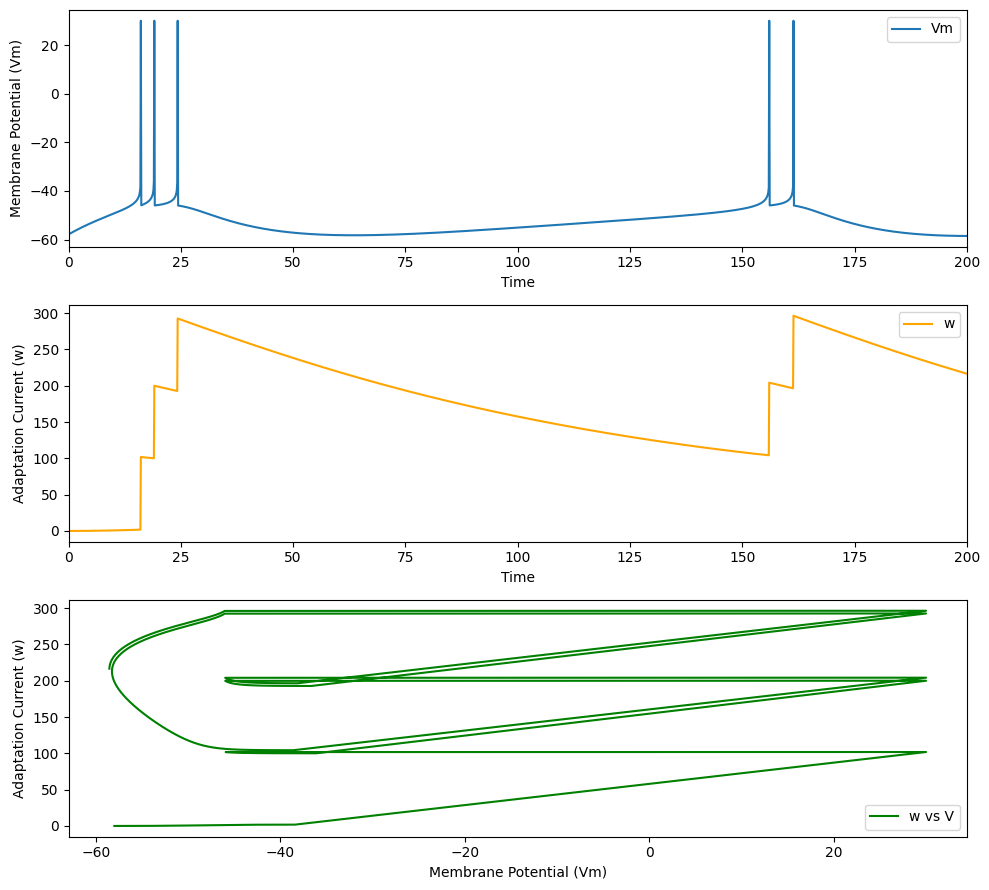

In [ ]:
main()

Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron delayedAccelerating_1


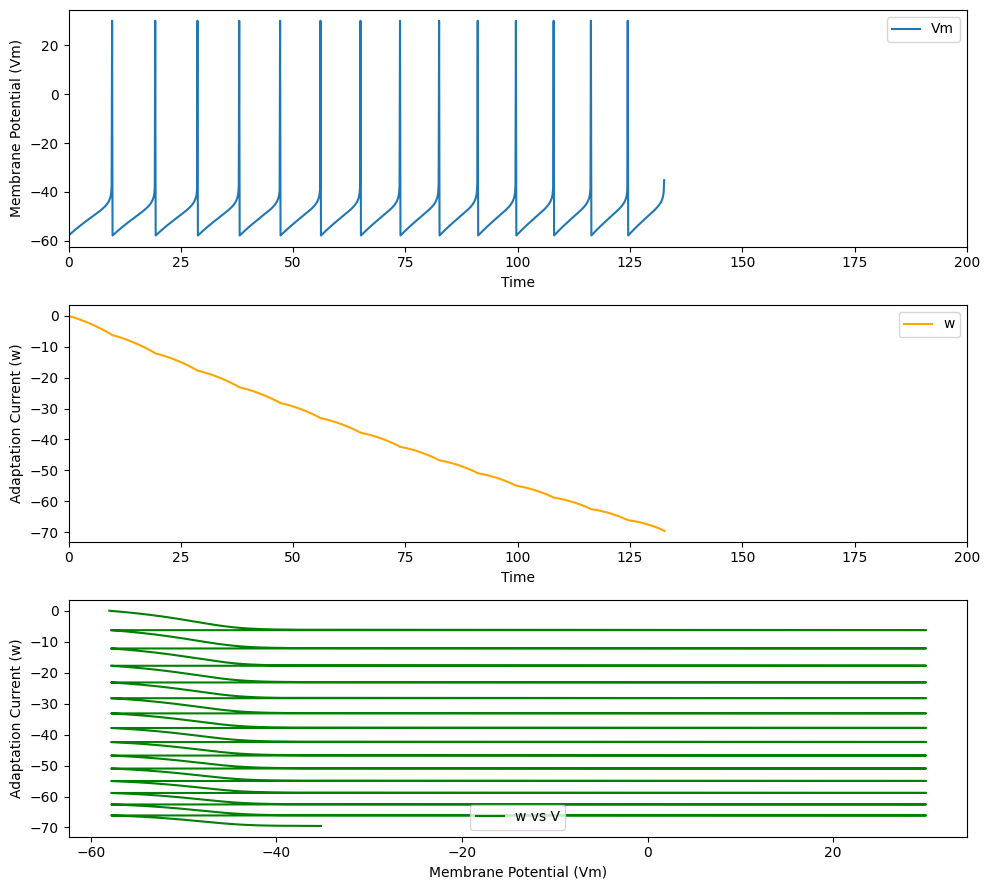

Results for neuron delayedAccelerating_1
Vm: [-58, -57.83231627748686, -57.66559556919004, -57.49983023641041, -57.335012568880806, -57.17113477719228, -57.00818898477967, -56.846167219441554, -56.68506140436797, -56.52486334864787, -56.3655647372262, -56.207157120278794, -56.04963190197086, -55.89298032856277, -55.73719347582401, -55.582262235713515, -55.42817730228145, -55.274929156743916, -55.12250805167856, -54.97090399428452, -54.82010672864576, -54.67010571693149, -54.52089011946167, -54.3724487735593, -54.224770171103806, -54.07784243469212, -53.93165329230492, -53.78619005036564, -53.64143956506861, -53.49738821184011, -53.35402185278198, -53.211325801931565, -53.069284788153766, -52.92788291546086, -52.78710362053273, -52.646929627184356, -52.50734289749805, -52.36832457930461, -52.22985494965968, -52.091913353918315, -51.95447813996174, -51.817526587073765, -51.681034828899804, -51.54497776984752, -51.409328994202745, -51.274060667136155, -51.13914342666265, -51.0045462654837

In [63]:
simulator = NeuronSimulator(480, 0, 200, 0.1, 1, "delayedAccelerating")
simulator.run_simulation()
simulator.plot_results()
simulator.print_results()

Enter the number of neurons: 1
Enter input current for the neurons: 400
Enter start time for the experiment: 0
Enter end time for the experiment: 200
Enter time step for the experiment: 0.1
Enter neuron type: delayedRegularBursting
Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron delayedRegularBursting_1


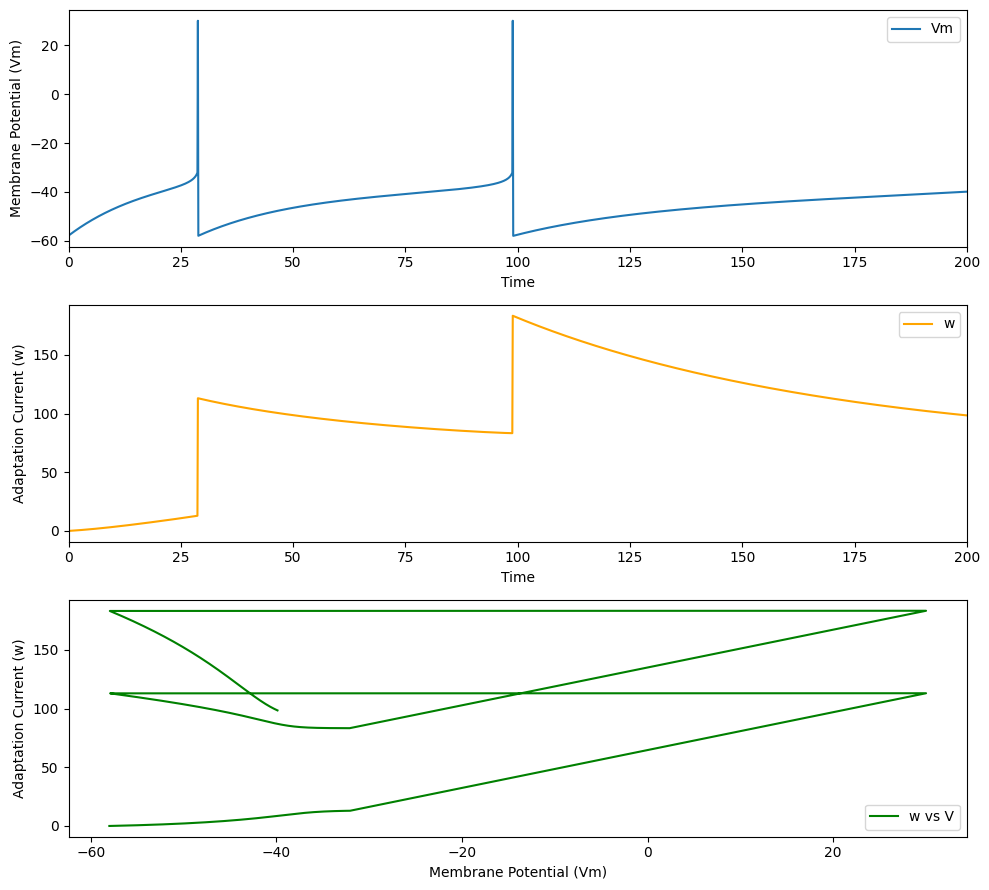

In [ ]:
main()

Enter the number of neurons: 1
Enter input current for the neurons: 250
Enter start time for the experiment: 0
Enter end time for the experiment: 200
Enter time step for the experiment: 0.1
Enter neuron type: transientSpiking
Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron transientSpiking_1


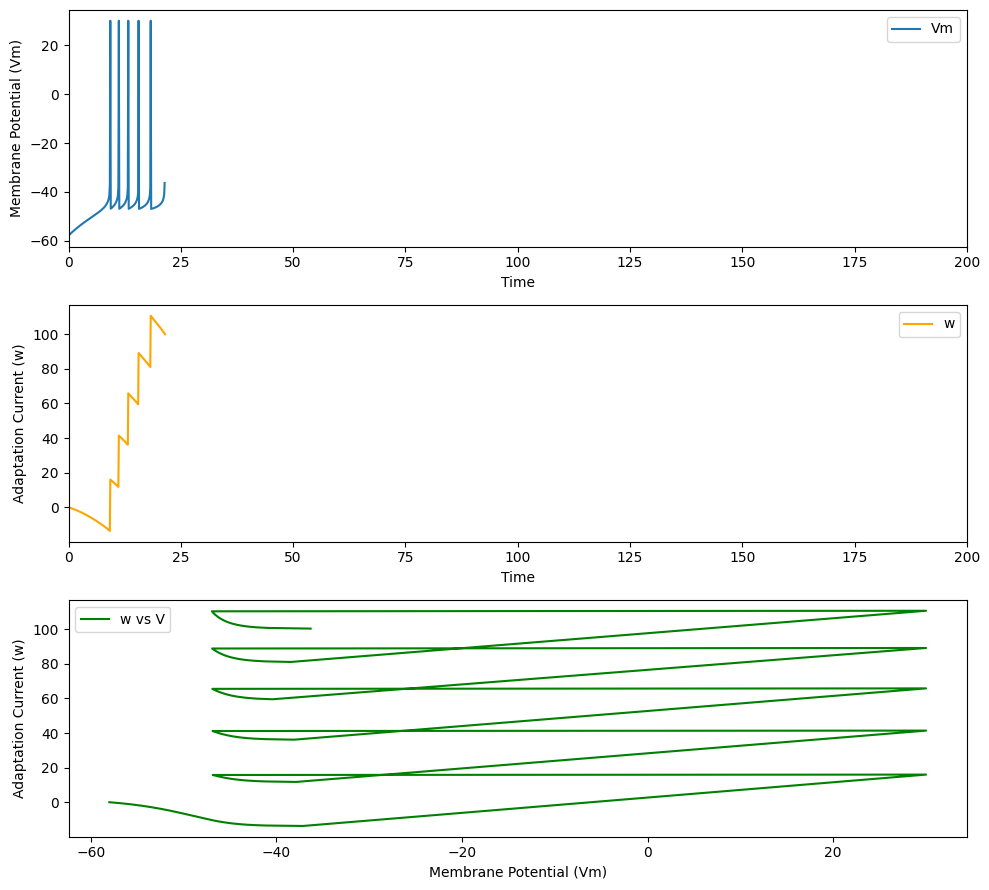

In [ ]:
main()

Enter the number of neurons: 1
Enter input current for the neurons: 160
Enter start time for the experiment: 0
Enter end time for the experiment: 200
Enter time step for the experiment: 0.1
Enter neuron type: irregularSpiking
Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron irregularSpiking_1


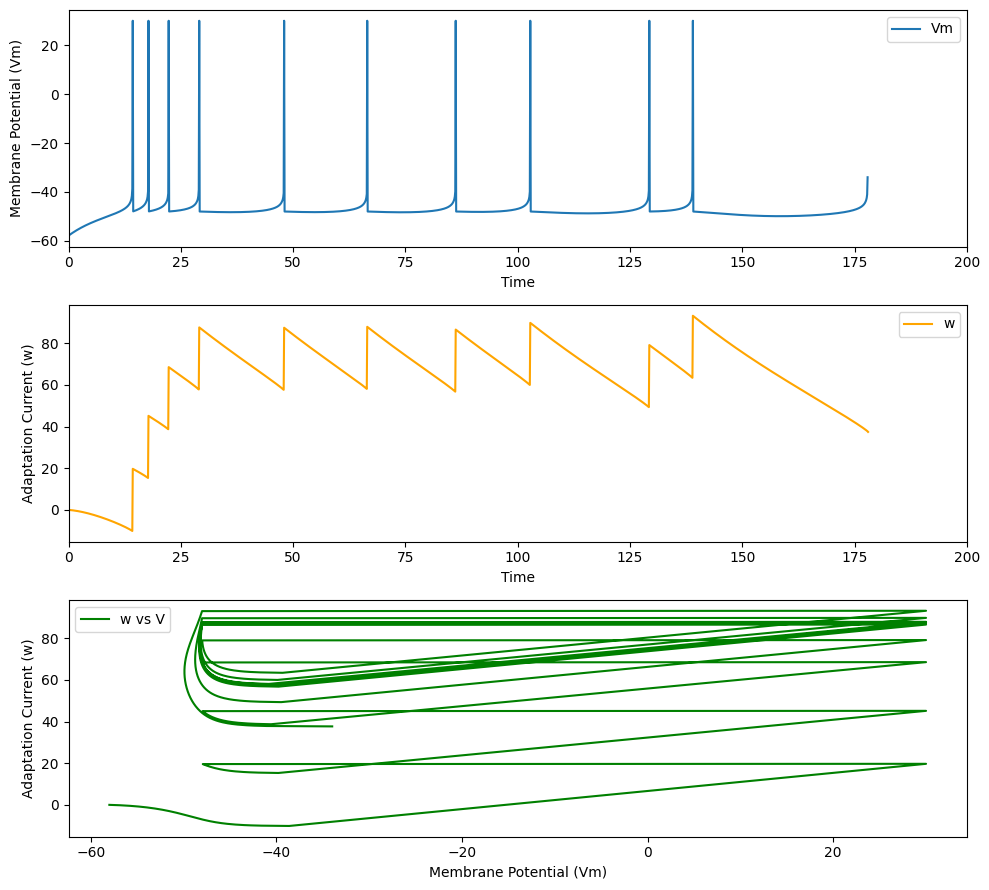

In [ ]:
main()

Enter the number of neurons: 5
Enter input current for the neurons: 500
Enter start time for the experiment: 0
Enter end time for the experiment: 200
Enter time step for the experiment: 0.1
Enter neuron type: tonic
Inside AdEx firing...
Inside AdEx store data...
Inside AdEx firing...
Inside AdEx store data...
Inside AdEx firing...
Inside AdEx store data...
Inside AdEx firing...
Inside AdEx store data...
Inside AdEx firing...
Inside AdEx store data...
Plotting results for neuron tonic_1


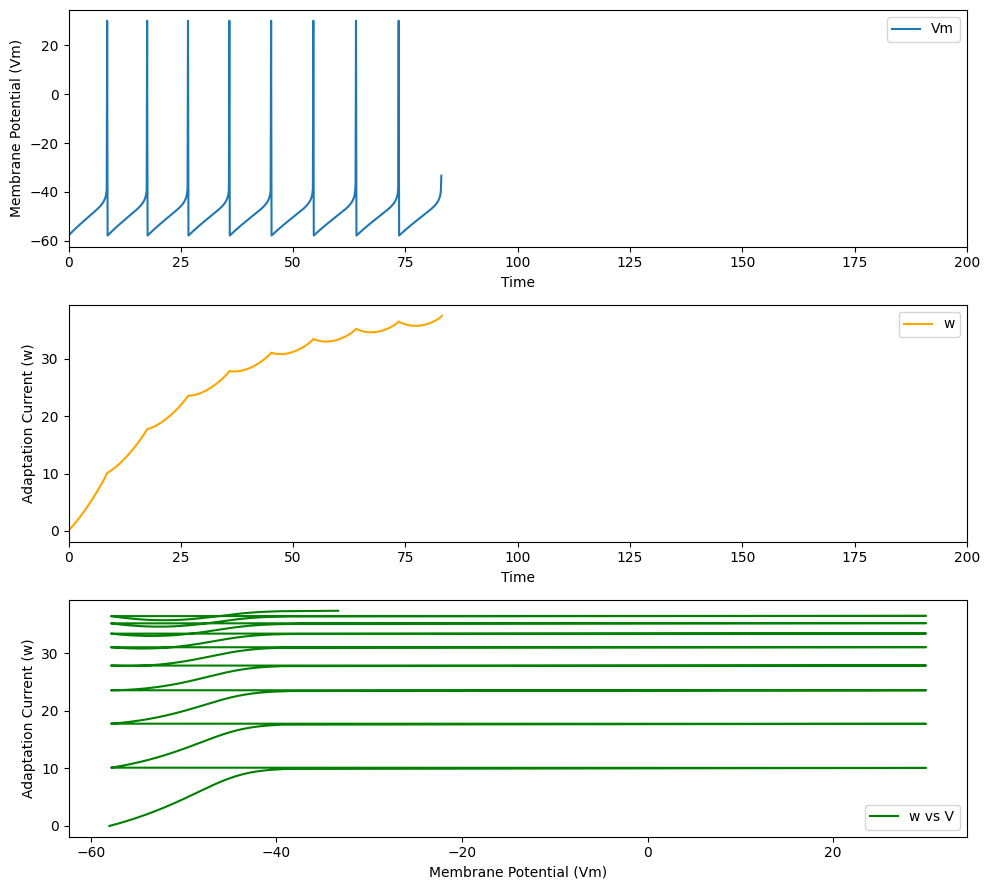

Plotting results for neuron tonic_2


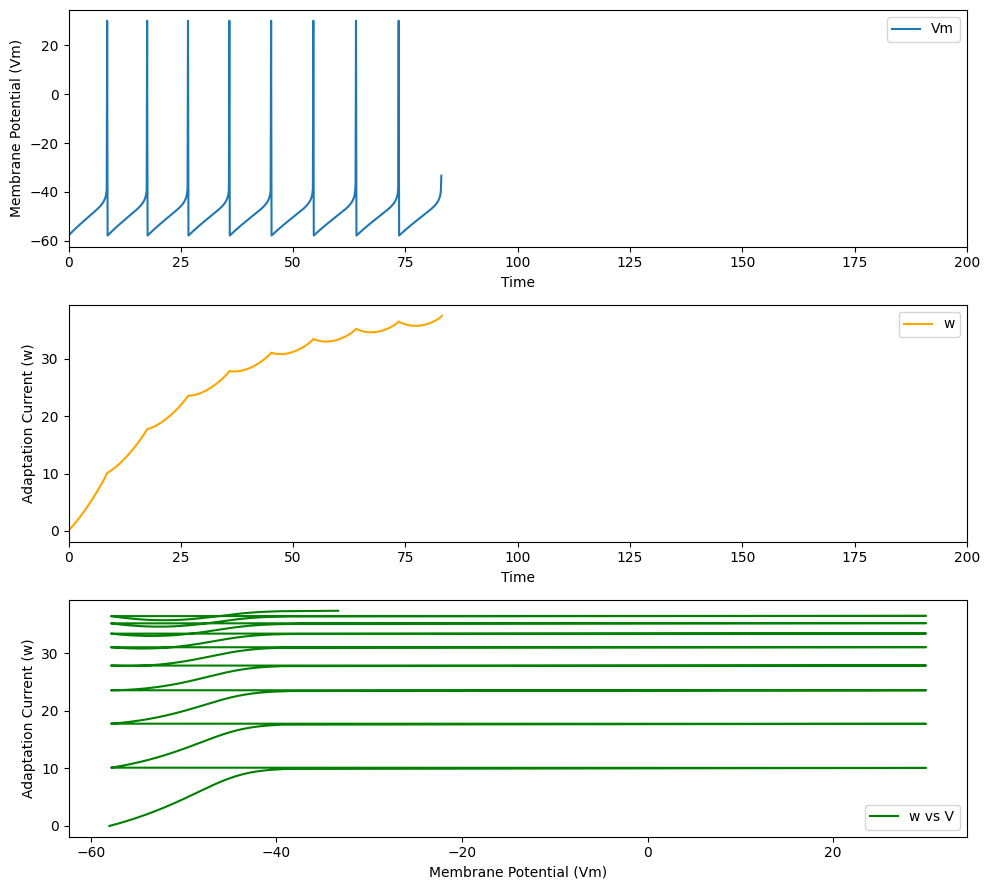

Plotting results for neuron tonic_3


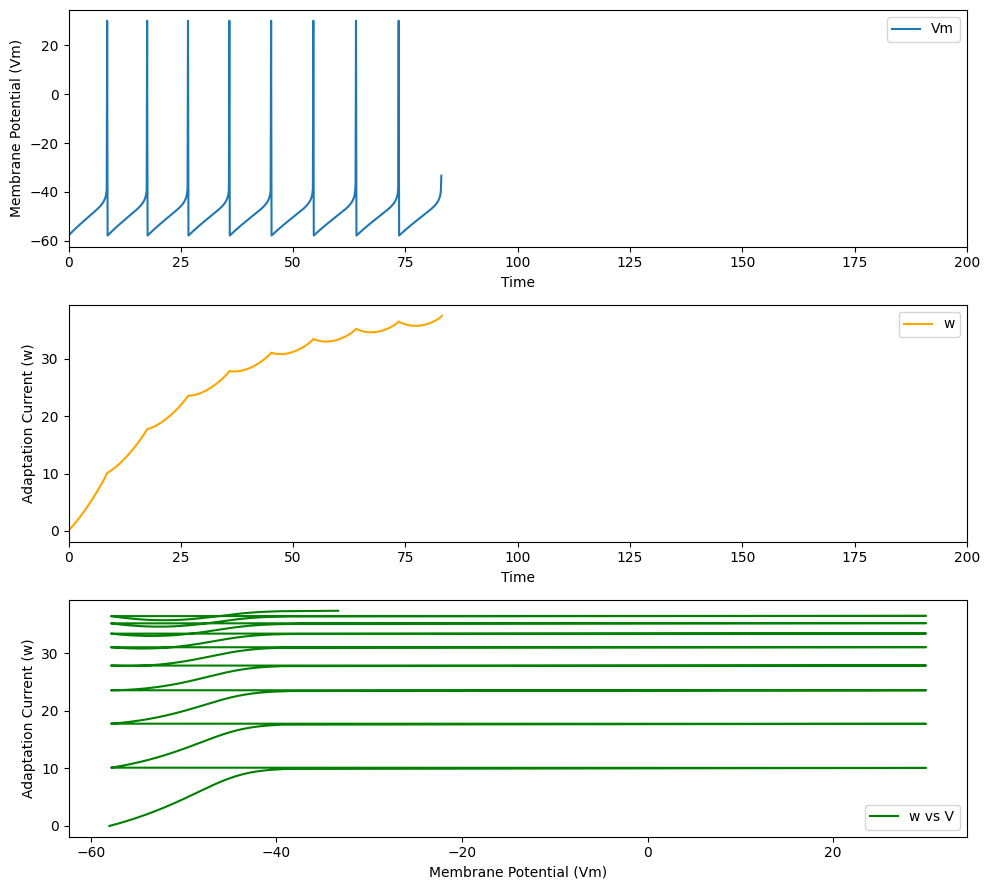

Plotting results for neuron tonic_4


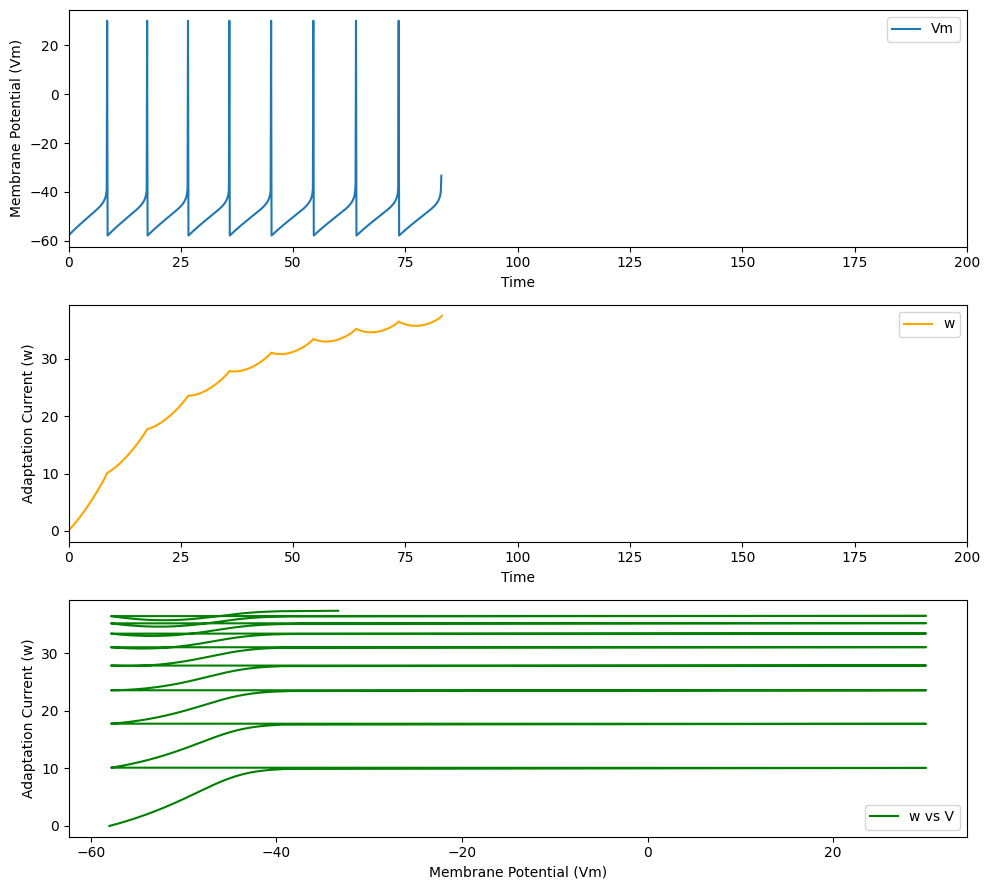

Plotting results for neuron tonic_5


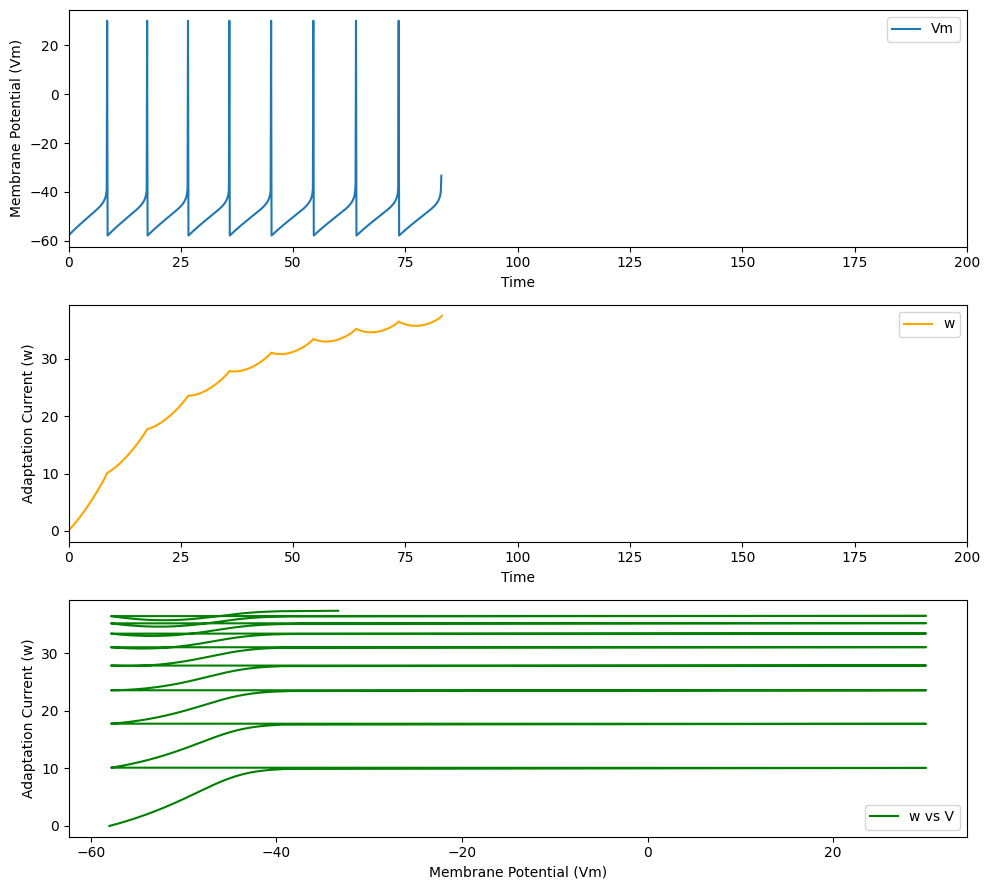

In [ ]:
main()